In [1]:
import os
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile
import warnings

warnings.filterwarnings("ignore")

In [2]:
os.listdir('./input/')

['.ipynb_checkpoints', 'right.wav', 'tensorflow-speech-recognition-challenge']

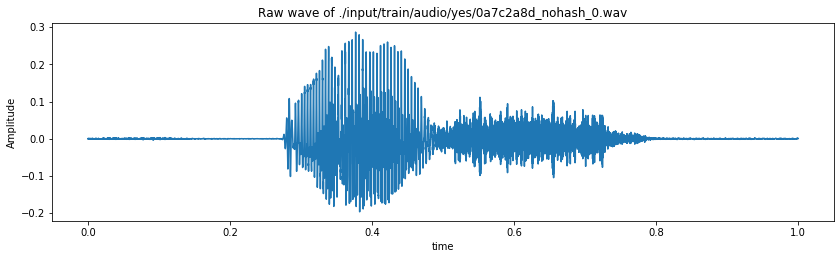

In [3]:
train_audio_path = './input/tensorflow-speech-recognition-challenge/train/audio/'
samples, sample_rate = librosa.load(train_audio_path+'yes/0a7c2a8d_nohash_0.wav', sr = 16000)
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + './input/train/audio/yes/0a7c2a8d_nohash_0.wav')
ax1.set_xlabel('time')
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)

In [4]:
ipd.Audio(samples, rate=sample_rate)

In [5]:
print(sample_rate)

16000


In [6]:
samples = librosa.resample(samples, sample_rate, 8000)
ipd.Audio(samples, rate=8000)

In [7]:
labels=os.listdir(train_audio_path)

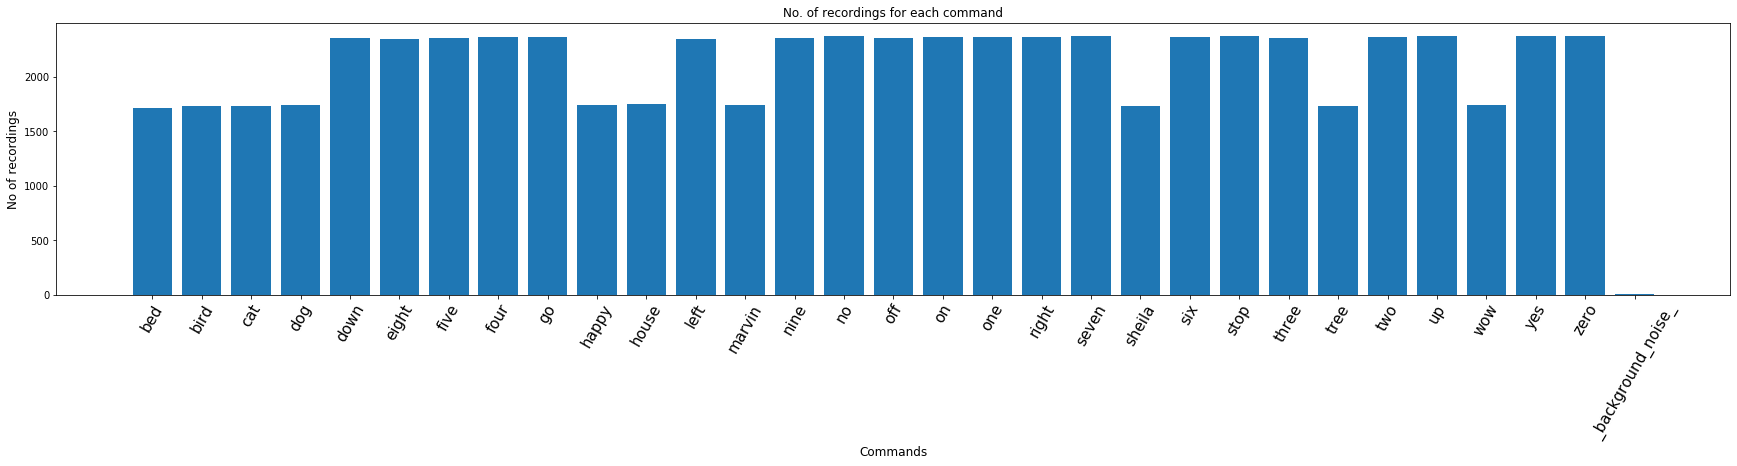

In [8]:
#dla każdej etykiety z listy kartotek znajdujemy liczbę plików audio w tej kartotece
no_of_recordings=[]
for label in labels:
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    no_of_recordings.append(len(waves))
    
#wykres
plt.figure(figsize=(30,5))
index = np.arange(len(labels))
plt.bar(index, no_of_recordings)
plt.xlabel('Commands', fontsize=12)
plt.ylabel('No of recordings', fontsize=12)
plt.xticks(index, labels, fontsize=15, rotation=60)
plt.title('No. of recordings for each command')
plt.show()

In [9]:
labels=["yes", "no", "left", "right", "stop"]

(array([8.0000e+00, 1.5000e+01, 1.7000e+01, 6.6000e+01, 5.9000e+01,
        7.8000e+01, 1.7200e+02, 2.1200e+02, 2.7200e+02, 1.0953e+04]),
 array([0.418 , 0.4762, 0.5344, 0.5926, 0.6508, 0.709 , 0.7672, 0.8254,
        0.8836, 0.9418, 1.    ]),
 <a list of 10 Patch objects>)

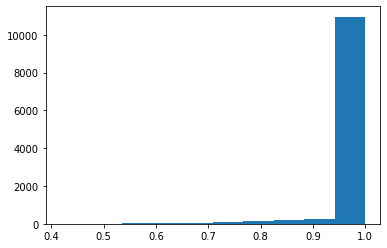

In [10]:
duration_of_recordings=[]
for label in labels:
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        sample_rate, samples = wavfile.read(train_audio_path + '/' + label + '/' + wav)
        duration_of_recordings.append(float(len(samples)/sample_rate))
    
plt.hist(np.array(duration_of_recordings))

In [11]:
train_audio_path = './input/tensorflow-speech-recognition-challenge/train/audio/'

all_wave = []
all_label = []
for label in labels:
    print(label)
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        samples, sample_rate = librosa.load(train_audio_path + '/' + label + '/' + wav, sr = 16000)
        samples = librosa.resample(samples, sample_rate, 8000)
        if(len(samples)== 8000) : 
            all_wave.append(samples)
            all_label.append(label)

yes
no
left
right
stop


In [12]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y=le.fit_transform(all_label)
classes= list(le.classes_)

In [13]:
from keras.utils import np_utils
y=np_utils.to_categorical(y, num_classes=len(labels))

Using TensorFlow backend.


In [14]:
all_wave = np.array(all_wave).reshape(-1,8000,1)

In [15]:
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(np.array(all_wave),np.array(y),stratify=y,test_size = 0.2,random_state=777,shuffle=True)

In [16]:
from keras.layers import Dense, Dropout, Flatten, Conv1D, Input, MaxPooling1D
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
K.clear_session()

inputs = Input(shape=(8000,1))

#First Conv1D layer
conv = Conv1D(8,13, padding='valid', activation='relu', strides=1)(inputs)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Second Conv1D layer
conv = Conv1D(16, 11, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Third Conv1D layer
conv = Conv1D(32, 9, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Fourth Conv1D layer
conv = Conv1D(64, 7, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Flatten layer
conv = Flatten()(conv)

#Dense Layer 1
conv = Dense(256, activation='relu')(conv)
conv = Dropout(0.3)(conv)

#Dense Layer 2
conv = Dense(128, activation='relu')(conv)
conv = Dropout(0.3)(conv)

outputs = Dense(len(labels), activation='softmax')(conv)

model = Model(inputs, outputs)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 8000, 1)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 7988, 8)           112       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 2662, 8)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2662, 8)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 2652, 16)          1424      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 884, 16)           0         
_____________________________________________________

In [17]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])

In [18]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001) 
mc = ModelCheckpoint('best_model.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [19]:
history=model.fit(x_tr, y_tr ,epochs=6, callbacks=[es,mc], batch_size=32, validation_data=(x_val,y_val))

Instructions for updating:
Use tf.cast instead.
Train on 8599 samples, validate on 2150 samples
Epoch 1/6
8599/8599 [==============================] - 74s 9ms/step - loss: 1.5564 - acc: 0.2822 - val_loss: 1.4199 - val_acc: 0.3763

Epoch 00001: val_acc improved from -inf to 0.37628, saving model to best_model.hdf5
Epoch 2/6
8599/8599 [==============================] - 75s 9ms/step - loss: 1.1651 - acc: 0.5272 - val_loss: 1.0559 - val_acc: 0.5953

Epoch 00002: val_acc improved from 0.37628 to 0.59535, saving model to best_model.hdf5
Epoch 3/6
8599/8599 [==============================] - 74s 9ms/step - loss: 0.8603 - acc: 0.6725 - val_loss: 0.9296 - val_acc: 0.6302

Epoch 00003: val_acc improved from 0.59535 to 0.63023, saving model to best_model.hdf5
Epoch 4/6
8599/8599 [==============================] - 75s 9ms/step - loss: 0.6489 - acc: 0.7637 - val_loss: 0.5954 - val_acc: 0.7823

Epoch 00004: val_acc improved from 0.63023 to 0.78233, saving model to best_model.hdf5
Epoch 5/6
8599/8599

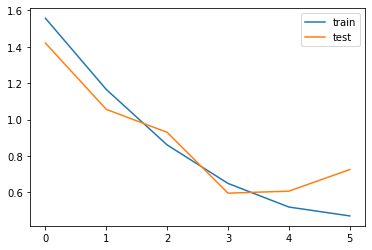

In [20]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [21]:
from keras.models import load_model
model=load_model('best_model.hdf5')

In [39]:
def predict(audio):
    prob=model.predict(audio.reshape(-1,8000,1))
    print(prob)
    index=np.argmax(prob[0])
    return classes[index]

In [63]:
import random
index=random.randint(0,len(x_val)-1)
samples=x_val[index].ravel()
print("Audio:",classes[np.argmax(y_val[index])])
ipd.Audio(samples, rate=8000)

Audio: left


In [64]:
print("Text:",predict(samples))

[[0.20958365 0.04093651 0.0647779  0.65854603 0.02615595]]
Text: stop


In [25]:
filepath='./input'

In [65]:
import sounddevice as sd
import soundfile as sf

samplerate = 16000  
duration = 1 # seconds
filename = './right.wav'
print("start")
mydata = sd.rec(int(samplerate * duration), samplerate=samplerate,
    channels=1, blocking=True)
print("end")
sd.wait()
sf.write(filepath + '/' + filename, mydata, samplerate)

start
end


In [66]:
os.listdir(filepath)

['.ipynb_checkpoints', 'right.wav', 'tensorflow-speech-recognition-challenge']

In [67]:
#reading the voice commands
samples, sample_rate = librosa.load(filepath + '/' + filename, sr = 16000)
samples = librosa.resample(samples, sample_rate, 8000)
ipd.Audio(samples,rate=8000)              

In [68]:
#converting voice commands to text
predict(samples)

[[0.09478857 0.17088583 0.51555693 0.10381716 0.11495158]]


'right'

In [30]:
def predictLabel(audio):
    prob=model.predict(audio.reshape(-1,8000,1))
    return np.argmax(prob[0])

In [31]:
predicted=[predictLabel(x) for x in x_val]

In [32]:
y_valLabels=[np.argmax(y) for y in y_val]

In [33]:
from sklearn.metrics import classification_report, confusion_matrix

cm = confusion_matrix(y_valLabels, predicted)
print(cm)
print(classification_report(y_valLabels, predicted))

[[204   6  11  43 169]
 [  8 307  19  29  57]
 [ 19   5 362  14  31]
 [ 11   6   4 406   8]
 [ 12   2   2  12 403]]
              precision    recall  f1-score   support

           0       0.80      0.47      0.59       433
           1       0.94      0.73      0.82       420
           2       0.91      0.84      0.87       431
           3       0.81      0.93      0.86       435
           4       0.60      0.94      0.73       431

    accuracy                           0.78      2150
   macro avg       0.81      0.78      0.78      2150
weighted avg       0.81      0.78      0.78      2150



In [34]:
print(classes)

['left', 'no', 'right', 'stop', 'yes']
